## Using VGG16 to Transfer learning and fine-tuning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

## show all the pretrained base models

In [2]:
dir(tf.keras.applications)

['ConvNeXtBase',
 'ConvNeXtLarge',
 'ConvNeXtSmall',
 'ConvNeXtTiny',
 'ConvNeXtXLarge',
 'DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'EfficientNetV2B0',
 'EfficientNetV2B1',
 'EfficientNetV2B2',
 'EfficientNetV2B3',
 'EfficientNetV2L',
 'EfficientNetV2M',
 'EfficientNetV2S',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'RegNetX002',
 'RegNetX004',
 'RegNetX006',
 'RegNetX008',
 'RegNetX016',
 'RegNetX032',
 'RegNetX040',
 'RegNetX064',
 'RegNetX080',
 'RegNetX120',
 'RegNetX160',
 'RegNetX320',
 'RegNetY002',
 'RegNetY004',
 'RegNetY006',
 'RegNetY008',
 'RegNetY016',
 'RegNetY032',
 'RegNetY040',
 'RegNetY064',
 'RegNetY080',
 'RegNetY120',
 'RegNetY160',
 'RegNetY320',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'Re

Download eurSat Dataset

In [4]:
os.mkdir('data')

import requests
url = "https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip"
req = requests.get(url, stream =True)
with open("data/EuroSAT_RGB.zip", 'wb') as f:
  for chunk in req.iter_content(chunk_size=1024):
    f.write(chunk)

# Unzip
import zipfile
with zipfile.ZipFile('data/EuroSAT_RGB.zip', 'r') as zip_ref:
    zip_ref.extractall('data/EuroSAT_RGB')

In [5]:
os.listdir('data/EuroSAT_RGB/EuroSAT_RGB')

['Pasture',
 'River',
 'HerbaceousVegetation',
 'PermanentCrop',
 'AnnualCrop',
 'Industrial',
 'Forest',
 'Highway',
 'Residential',
 'SeaLake']

# split the train set and validation set

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import PIL

data_path = 'data/EuroSAT_RGB/EuroSAT_RGB'

import pathlib
data_dir = pathlib.Path(data_path).with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
# count all samples
print(image_count)

27000


In [7]:
batch_size = 32
img_height = 64
img_width = 64

# get train set
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# get validation set
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.


In [8]:
# show class
class_names = train_ds.class_names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## check data

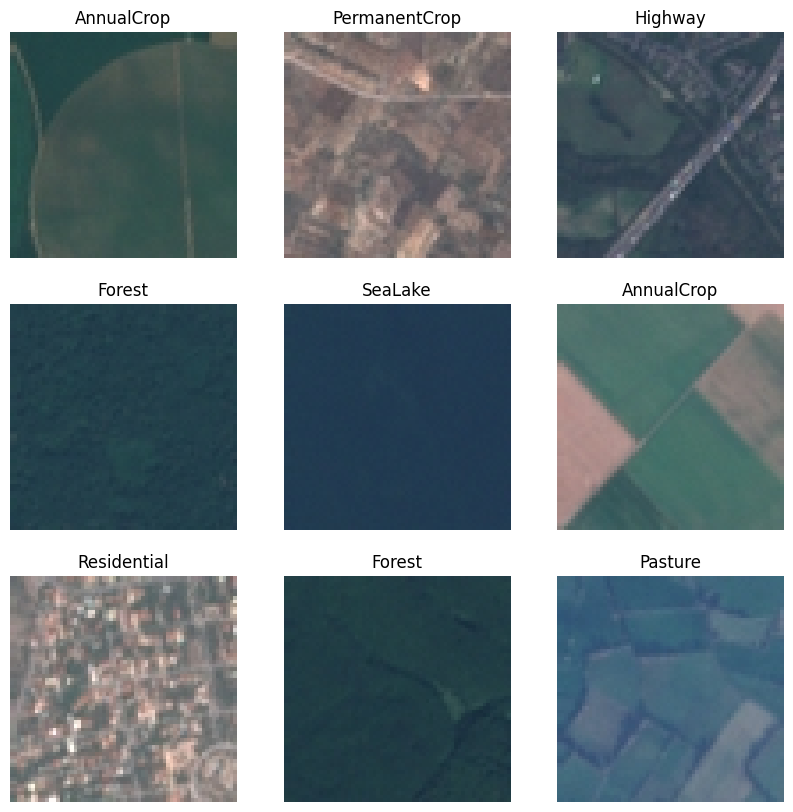

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Preprepare and preprocess

In [10]:
# preload the data to the cache
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
# use the 'preprocess_input' to normalized dataset.
preprocess_input = tf.keras.applications.vgg16.preprocess_input

normalized_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

-43.68 24.060997


## Add dara augmentation layer

In [11]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

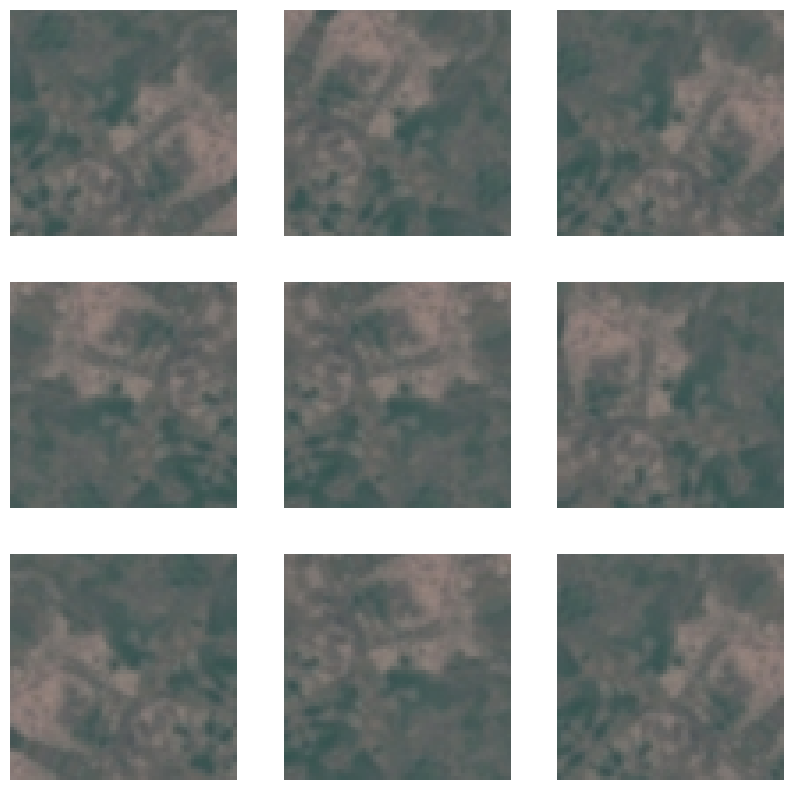

In [12]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Load in the pretrained base model (and pretrained weights)

In [13]:
print(first_image.shape)

(64, 64, 3)


In [14]:
IMG_SIZE = (img_height, img_width, 3)
base_model = tf.keras.applications.vgg16.VGG16(input_shape=IMG_SIZE, include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


## show the pretrained model output

In [15]:
image_batch, label_batch = next(iter(normalized_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 2, 2, 512)


## avoid the parameters in pretrained model to be trained

In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Add the top layer to fit the output of data

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [19]:
prediction_layer = tf.keras.layers.Dense(10)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 10)


In [20]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 sequential (Sequential)     (None, 64, 64, 3)         0         
                                                                 
 tf.__operators__.getitem (  (None, 64, 64, 3)         0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 64, 64, 3)         0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0     

## transfer the pretrained model

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

169/169 [==============================] - 248s 1s/step - loss: 11.2552 - accuracy: 0.0781


In [24]:
history = model.fit(train_ds, epochs=initial_epochs, validation_data=val_ds)

Epoch 1/10
675/675 [==============================] - 1260s 2s/step - loss: 5.1299 - accuracy: 0.3153 - val_loss: 2.2558 - val_accuracy: 0.5769
Epoch 2/10
675/675 [==============================] - 1259s 2s/step - loss: 2.2016 - accuracy: 0.5889 - val_loss: 1.3617 - val_accuracy: 0.7309
Epoch 3/10
675/675 [==============================] - 1272s 2s/step - loss: 1.4971 - accuracy: 0.6928 - val_loss: 1.0784 - val_accuracy: 0.7863
Epoch 4/10
675/675 [==============================] - 1258s 2s/step - loss: 1.2047 - accuracy: 0.7422 - val_loss: 0.9279 - val_accuracy: 0.8119
Epoch 5/10
675/675 [==============================] - 1310s 2s/step - loss: 1.0010 - accuracy: 0.7746 - val_loss: 0.8306 - val_accuracy: 0.8267
Epoch 6/10
675/675 [==============================] - 1271s 2s/step - loss: 0.8841 - accuracy: 0.7953 - val_loss: 0.7449 - val_accuracy: 0.8428
Epoch 7/10
675/675 [==============================] - 1283s 2s/step - loss: 0.7926 - accuracy: 0.8081 - val_loss: 0.6996 - val_accuracy:

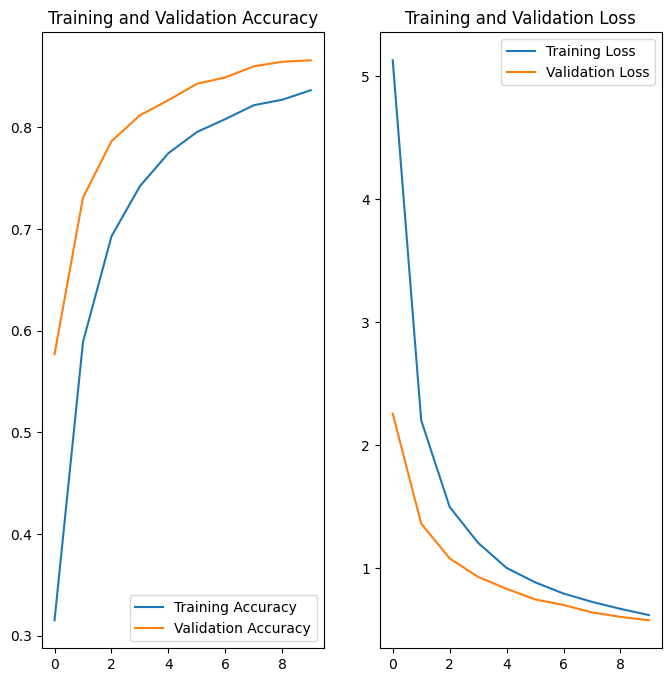

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Fine tuning

In [33]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 13

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

Number of layers in the base model:  19


In [34]:
len(model.trainable_variables)

10

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=val_ds)

Epoch 10/20
317/675 [=============>................] - ETA: 14:59 - loss: 0.4837 - accuracy: 0.8597

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()